 # Task 4: Training Process
 
 **Objective:** Train the Neural Network using appropriate optimization strategies, handle class imbalance, implement overfitting mitigation (Early Stopping, Dropout), and monitor performance.


In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
import os
import sys

# Setup Paths
PROJECT_ROOT = Path(os.getcwd()).parent if os.getcwd().endswith('notebooks') else Path(os.getcwd())
sys.path.append(str(PROJECT_ROOT))

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"

# Create models directory if it doesn't exist
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Import custom modules
from src.models.model_arch import build_model
from src.models.train import train_model

# Configure Matplotlib
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

2026-01-03 07:30:56.465146: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-03 07:30:57.244880: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-03 07:31:01.509579: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/alazar/dev/crash-learner/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Load Processed Data
Load the Parquet files created in Task 2.

In [2]:
X_train = pd.read_parquet(PROCESSED_DIR / "X_train.parquet")
y_train = pd.read_parquet(PROCESSED_DIR / "y_train.parquet")
X_val = pd.read_parquet(PROCESSED_DIR / "X_val.parquet")
y_val = pd.read_parquet(PROCESSED_DIR / "y_val.parquet")

print(f"Training Samples: {X_train.shape[0]}")
print(f"Validation Samples: {X_val.shape[0]}")

# Get Dimensions
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train['target']))

Training Samples: 42002
Validation Samples: 9001


## 2. Initialize Model
We use the architecture defined in Task 3.
 *   **Optimizer:** Adam (Adaptive Moment Estimation) - standard for structured data.
 *   **Learning Rate:** 0.001 (Default start point).

In [4]:
model = build_model(
    input_dim=input_dim, 
    num_classes=num_classes,
    dropout_rate=0.4, # Slightly increased dropout for better regularization
    l2_reg=0.001
)

2026-01-03 07:32:39.993311: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


 ## 3. Execute Training Loop
 *   **Batch Size:** 32 (Good balance between speed and stability).
 *   **Epochs:** 100 (Early Stopping will likely cut this short).
 *   **Class Weights:** Applied automatically by our `train_model` function to handle imbalance.


In [8]:
history = train_model(
    model=model,
    X_train=X_train, 
    y_train=y_train, 
    X_val=X_val, 
    y_val=y_val,
    batch_size=32,
    epochs=10,
    model_save_path=str(MODELS_DIR / "best_model.keras")
)

[INFO] Class Weights computed: {np.int64(0): np.float64(6.747309236947791), np.int64(1): np.float64(0.3158876396044072), np.int64(2): np.float64(0.7611126211832926), np.int64(3): np.float64(2.7002250080360013), np.int64(4): np.float64(525.025)}
[INFO] Starting training for 10 epochs with batch size 32...
Epoch 1/10
   8/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9546 - loss: 0.2805   

2026-01-03 07:37:52.042937: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 38641840 exceeds 10% of free system memory.


1304/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9419 - loss: 0.3135
Epoch 1: val_accuracy improved from None to 0.97456, saving model to /home/alazar/dev/crash-learner/models/best_model.keras

Epoch 1: finished saving model to /home/alazar/dev/crash-learner/models/best_model.keras
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9437 - loss: 0.3738 - val_accuracy: 0.9746 - val_loss: 0.2781 - learning_rate: 5.0000e-04
Epoch 2/10
1308/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9474 - loss: 0.2797
Epoch 2: val_accuracy improved from 0.97456 to 0.97556, saving model to /home/alazar/dev/crash-learner/models/best_model.keras

Epoch 2: finished saving model to /home/alazar/dev/crash-learner/models/best_model.keras
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9498 - loss: 0.2698 - val_accuracy: 0.9756 - val_loss: 0.2625 - learning_rate: 5.0000e-04
Epoch 3/10
1311/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9486 - loss: 0.3701
Epoch 3: val_accuracy

## 4. Monitor Training Progress
Visualize Loss and Accuracy curves to detect overfitting or underfitting.

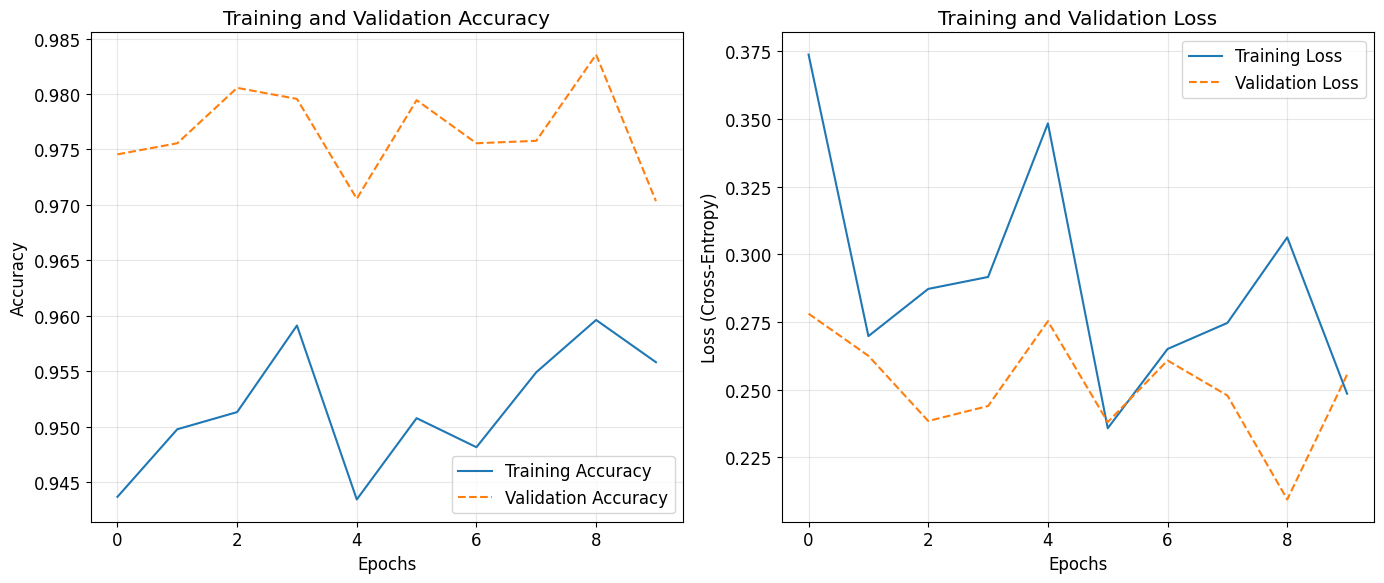

In [9]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle='--')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Cross-Entropy)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # Save
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "training_curves.svg", format='svg')
    plt.show()

plot_history(history)

 ## 5. Discussion on Training Results
 
 ### Observations:
 1.  **Loss Curve:** Look for the point where `Validation Loss` stops decreasing and starts rising. This indicates the start of overfitting. Our **EarlyStopping** callback should have stopped training shortly after this point.
 2.  **Accuracy Gap:** A large gap between Training Accuracy (high) and Validation Accuracy (low) indicates overfitting. 
     *   *Mitigation:* If the gap is wide, we might need to increase `dropout_rate` in `build_model` or increase `l2_reg`.
 3.  **Class Imbalance Impact:** Because we used **Class Weights**, the raw accuracy might be lower than a baseline model that just predicts the majority class ("Minor"), but the model is learning to distinguish the rarer classes (Serious/Fatal).
 
 ### Next Steps:
 The best model has been saved to `models/best_model.keras`. We will use this in **Task 5** to evaluate performance on the unseen Test Set.